In [1]:
#Misc
import signal
import sys
sys.path.append("../../")
from utils import *
import utils
#Torch
import torch
from torch.utils.data import DataLoader, TensorDataset
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
from torch.autograd import Variable
#Numpy-Matplotlib-tqdm-sklearn
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.model_selection import TimeSeriesSplit, ParameterGrid
#DynamicalSystems
from kooplearn.kernels import Linear, RBF
from kooplearn.estimators import KernelRidgeRegression, ReducedRankRegression

/usr/local/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


[KeOps] Warning : Cuda libraries were not detected on the system ; using cpu only mode


In [2]:
num_classes = 10
perm_data = build_sequential_data(num_classes=num_classes)

In [3]:
num_train_samples = 1000
torch_dataset = torch.from_numpy(data[perm_data])
dataset = data[perm_data]
X = dataset[:-1].reshape(-1, 28 * 28)
Y = dataset[1:].reshape(-1, 28*28)
CV = False

#### Optimizing Linear Hyperparameters

In [4]:
tsCV = TimeSeriesSplit(n_splits=2, max_train_size=num_train_samples)
d = X.shape[1]
tikhonov_regs = np.geomspace(1e0, 1e2, 20)
tikhonov_reg_linear = 48.3293 #CV
gamma_linear = d**-1 #CV
gammas = np.geomspace((d**-1)*1e-3, d**-1*(1e1), 20)
params = list(
    ParameterGrid(
        { 
            'tikhonov_reg': tikhonov_regs, 
            #'gamma': gammas,
        }
    )
)
backend = 'cpu'

In [5]:
if CV:
    error = np.empty((len(params), 2))
    for iter_idx, iterate in tqdm(enumerate(params), total=len(params)):      
        _err = []
        for train_index, test_index in tsCV.split(X):
            X_train, Y_train = X[train_index], Y[train_index]
            X_test, Y_test = X[test_index], Y[test_index]
            kernel = Linear(gamma=gamma_linear)
            model = KernelRidgeRegression(kernel, tikhonov_reg = tikhonov_reg_linear)
                
            model.fit(X_train, Y_train, backend = backend)
            _err.append(model.risk(X_test, Y_test))
        _err = np.array(_err)
        error[iter_idx, 0] = np.mean(_err)
        error[iter_idx, 1] = np.std(_err)

In [6]:
if CV:
    fig, ax = plt.subplots()     
    mean = error[:,0]
    std = error[:,1]
    ax.fill_between(coef0, mean - std, mean + std, alpha = 0.5)
    ax.plot(coef0, mean, '.-')
    ax.margins(0)
    ax.set_ylabel("Test error")
    ax.set_xscale('log')
    ax.set_yscale('log')

#### Optimizing RBF's hyperparameters

In [7]:
tsCV = TimeSeriesSplit(n_splits=2, max_train_size=num_train_samples)
d = X.shape[1]
tikhonov_regs = np.geomspace(1e-8, 1e-1, 20)
tikhonov_reg_RBF = 0.00785 #CV
length_scales = np.geomspace(d*1e-8, d*1e3, 20)
params = list(
    ParameterGrid(
        { 
            'tikhonov_reg': tikhonov_regs, 
            #'length_scale': length_scales,
        }
    )
)
backend = 'cpu'

In [8]:
if CV:
    error = np.empty((len(params), 2))
    for iter_idx, iterate in tqdm(enumerate(params), total=len(params)):      
        _err = []
        for train_index, test_index in tsCV.split(X):
            X_train, Y_train = X[train_index], Y[train_index]
            X_test, Y_test = X[test_index], Y[test_index]
            kernel = RBF(length_scale=d)
            model = KernelRidgeRegression(kernel, tikhonov_reg = iterate['tikhonov_reg'])
            model.fit(X_train, Y_train, backend = backend)
            _err.append(model.risk(X_test, Y_test))
        _err = np.array(_err)
        error[iter_idx, 0] = np.mean(_err)
        error[iter_idx, 1] = np.std(_err)

In [9]:
if CV:
    fig, ax = plt.subplots()     
    mean = error[:,0]
    std = error[:,1]
    ax.fill_between(tikhonov_regs, mean - std, mean + std, alpha = 0.5)
    ax.plot(tikhonov_regs, mean, '.-')
    ax.margins(0)
    ax.set_ylabel("Test error")
    ax.set_xscale('log')
    ax.set_yscale('log')

#### Train CNN-Kernel

In [10]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Sequential(         
            nn.Conv2d(
                in_channels=1,              
                out_channels=16,            
                kernel_size=5,              
                stride=1,                   
                padding=2,                  
            ),                              
            nn.ReLU(),                      
            nn.MaxPool2d(kernel_size=2),    
        )
        self.conv2 = nn.Sequential(         
            nn.Conv2d(16, 32, 5, 1, 2),     
            nn.ReLU(),                      
            nn.MaxPool2d(2),                
        )
        # fully connected layer, output 10 classes
        self.out = nn.Sequential(
            nn.Linear(32 * 7 * 7, 10)
        )
        
    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        # flatten the output of conv2 to (batch_size, 32 * 7 * 7)
        x = x.view(x.size(0), -1)       
        output = self.out(x)
        return output    # return x for visualization

def classifier_train(num_epochs, cnn, loader):
    
    cnn.train()
        
    # Train the model
    total_step = len(loader)
        
    for epoch in range(num_epochs):
        for i, (images, labels) in enumerate(loader):
            
            # gives batch data, normalize x when iterate train_loader
            b_x = Variable(images)   # batch x
            b_y = Variable(labels)   # batch y
            output = cnn(b_x)               
            loss = loss_func(output, b_y)
            
            # clear gradients for this training step   
            optimizer.zero_grad()           
            
            # backpropagation, compute gradients 
            loss.backward()    
            # apply gradients             
            optimizer.step()                  
        print ('Epoch [{}/{}], Loss: {:.4f}'.format(epoch + 1, num_epochs,loss.item()))

In [11]:
cnn_train_samples = num_train_samples
images = (torch_dataset[:(cnn_train_samples + 1)])[:,None,...]
targets = utils._train_data.targets[perm_data][:cnn_train_samples + 1]
dataset = TensorDataset(images, targets)
loader = torch.utils.data.DataLoader(dataset, batch_size=100, shuffle=True, num_workers=1)
cnn = CNN()
loss_func = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(cnn.parameters(), lr = 0.001)  

In [12]:
classifier_train(20, cnn, loader)

Epoch [1/20], Loss: 2.6268
Epoch [2/20], Loss: 0.2506
Epoch [3/20], Loss: 0.1007
Epoch [4/20], Loss: 0.0013
Epoch [5/20], Loss: 0.0001
Epoch [6/20], Loss: 0.0000
Epoch [7/20], Loss: 0.0008
Epoch [8/20], Loss: 0.0000
Epoch [9/20], Loss: 0.0001
Epoch [10/20], Loss: 0.0001
Epoch [11/20], Loss: 0.0000
Epoch [12/20], Loss: 0.0091
Epoch [13/20], Loss: 0.0006
Epoch [14/20], Loss: 0.0091
Epoch [15/20], Loss: 0.0016
Epoch [16/20], Loss: 0.0000
Epoch [17/20], Loss: 0.0000
Epoch [18/20], Loss: 0.0003
Epoch [19/20], Loss: 0.0000
Epoch [20/20], Loss: 0.0000


### Learning with Linear, RBF and DeepKernel

In [13]:
cnn_kernel = DeepKernel(cnn, softmax=True)
kernels = [Linear(gamma=gamma_linear), RBF(length_scale = 28*28), cnn_kernel]
tikhonov_regs = [tikhonov_reg_linear, tikhonov_reg_RBF, 1e-4]
trained_estimators = []
for k_idx, kernel in enumerate(kernels):
    K = ReducedRankRegression(kernel=kernel, rank=10, tikhonov_reg=tikhonov_regs[k_idx])
    X_train = X[:num_train_samples]
    Y_train = Y[:num_train_samples] 
    K.fit(X_train, Y_train, backend="cpu")
    trained_estimators.append(K)

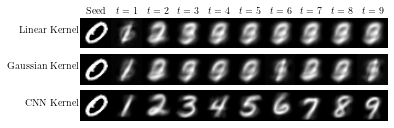

In [14]:
seed = 0 # int between 0 and 9
X_0 = X[num_train_samples + 0*num_classes + seed + 1][None, :].reshape(28,28)
_img_data = []
for row in range(len(trained_estimators)):
    estimator = trained_estimators[row]
    _kernel_name = estimator.kernel.__class__.__name__
    _imgs = [X_0]
    for col in range(num_classes):
        X_val = _imgs[-1].reshape(1, 28*28)
        Y_val = estimator.predict(X_val)
        Y_val = np.squeeze(Y_val).reshape(28,28)
        _imgs.append(Y_val)
    _img_data.append(_imgs)
data = np.array(_img_data)
num_classes = data.shape[1] - 1
labels = ['Linear Kernel', 'Gaussian Kernel', 'CNN Kernel']

fig_width = 5.5 #Inches
fig_height = 2 #Inches
fig, axes = plt.subplots(nrows = data.shape[0], ncols=num_classes, figsize=(fig_width, fig_height))
plt.subplots_adjust(wspace=0, hspace=0)
for row in range(data.shape[0]):
    for col in range(num_classes):
        ax = axes[row, col]
        ax.axis('off')
        Y_val = data[row, col]
        ax.imshow(Y_val, cmap="gray")
        if col == 0:
            ax.text(-2, 14, labels[row], ha='right')
        if row == 0:
            if col == 0:
                ax.text(14, -4, "Seed", ha='center')
            elif 0 < col < num_classes:
                ax.text(14, -4, r"$t = {}$".format(col), ha='center')
#plt.savefig(f"figs/{seed}_prediction.pdf", bbox_inches='tight')